In [1]:
# Import matplotlib dependencies
%matplotlib inline
from matplotlib import style
style.use("fivethirtyeight")
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib

In [2]:
# Import numpy and pandas 
import numpy as np
import pandas as pd

In [3]:
# Import datetime dependencies 
import datetime as dt 

In [4]:
# Import SQL Alchemy dependencies 
from sqlalchemy.sql import label
from sqlalchemy import Column, Integer, String, Numeric, Text, Float,Table,ForeignKey
from sqlalchemy.orm import Session

In [5]:
# Import jsonify from flask 
from flask import jsonify

# Reflect Tables into SQLAlchemy ORM

In [6]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func
from sqlalchemy.ext.declarative import declarative_base 

In [7]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [8]:
# Reflect an existing database into a new model
Base = automap_base()

# Reflect the tables
Base.prepare(engine, reflect=True)

In [9]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [10]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [11]:
# Inspect database for table names (should get same result as line 9 above)
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [12]:
# Get a list of column names and types
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [13]:
# Let's get a look at the measurement data 
engine.execute("SELECT * FROM Measurement LIMIT 5").fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0)]

In [14]:
# Now, let's look at the station data
engine.execute("SELECT * FROM Station LIMIT 5").fetchall()

[(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 (3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0),
 (4, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 (5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6)]

In [15]:
# Create our session (link) from Python to the DB
session = Session(bind=engine)

In [16]:
my_table = Table('Measurement', Base.metadata, 
    Column("station", String, ForeignKey("Stations.station")),
    autoload=True,autoload_with=engine)

# Exploratory Climate Analysis

In [17]:
# Find the last date 
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(last_date)

('2017-08-23',)


In [18]:
# Calculate the date 1 year ago from the last data point in the database
last_year = dt.date(2017, 8, 23) - dt.timedelta(days=365)
print(last_year)

2016-08-23


In [19]:
# Query for last 12 months of precipitation
last_year_prcp = session.query(Measurement.date, Measurement.prcp).\
        filter(Measurement.date >= '2016-08-24').filter(Measurement.date <= '2017-08-23').order_by(Measurement.date).all()

In [22]:
# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_df = pd.DataFrame(last_year_prcp)
prcp_df.set_index('date')
prcp_df.head()

,date,prcp
0,2016-08-24,0.08
1,2016-08-24,2.15
2,2016-08-24,2.28
3,2016-08-24,NaN
4,2016-08-24,1.22


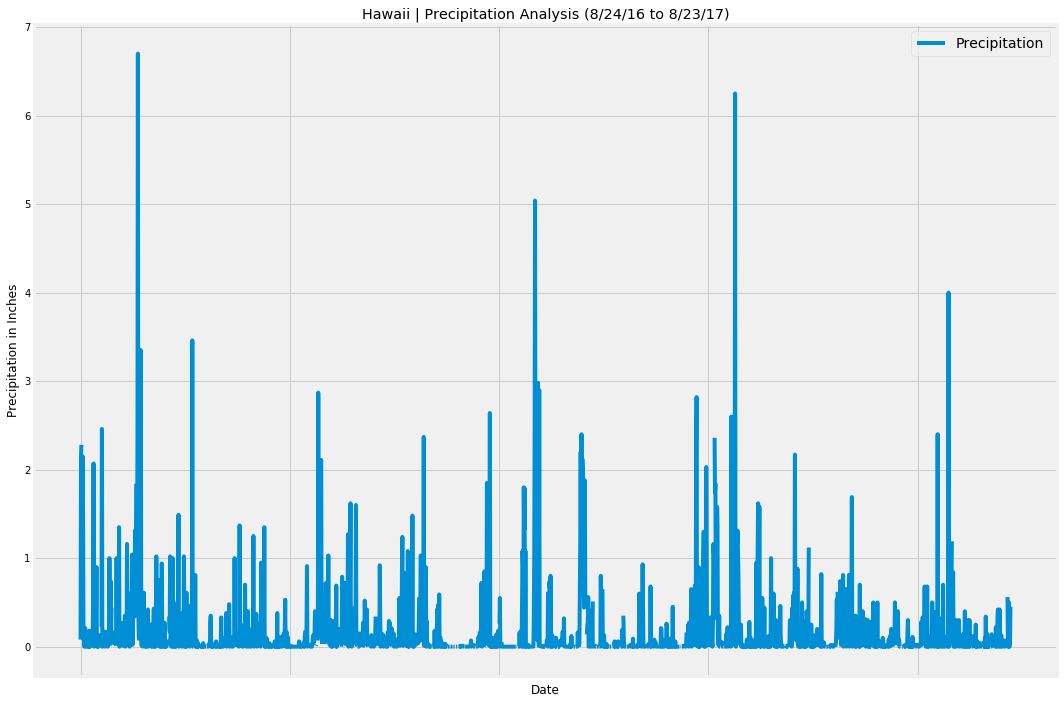

In [23]:
# Use Pandas Plotting with Matplotlib to plot the data
ax = prcp_df.plot("date", "prcp", linewidth=4, figsize=(15,10))
ax.set_title("Hawaii | Precipitation Analysis (8/24/16 to 8/23/17)")
ax.set_ylabel("Precipitation in Inches")
ax.set_xlabel("Date")
plt.style.use('fivethirtyeight')
plt.tight_layout()
plt.legend(["Precipitation"])
plt.savefig("Images/PrecipitationAnalysis_Hawaii_rjr.png")
plt.show()

In [24]:
# Use Pandas to calculate the summary statistics for the precipitation data
prcp_df.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Station analysis

In [25]:
# Design a query to show how many stations are available in this dataset?
stations_count = session.query(Measurement).group_by(Measurement.station).count()
print("There are {} stations in this dataset.".format(stations_count))

There are 9 stations in this dataset.


In [26]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active_count = session.query(Measurement.station, func.count(Measurement.station).label('count')).\
            group_by(Measurement.station).\
            order_by('count DESC').all()
active_count

/anaconda3/lib/python3.7/site-packages/sqlalchemy/sql/compiler.py:643: SAWarning: Can't resolve label reference 'count DESC'; converting to text() (this warning may be suppressed after 10 occurrences)
  util.ellipses_string(element.element))


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [27]:
# Print the station id for the most active station
most_active = session.query(Measurement.station, 
                                    func.count(Measurement.station).\
                                    label('count')).\
                                    group_by(Measurement.station).\
                                    order_by('count DESC').limit(1)[0][0]
print("The most active station during the time period of the analysis was " + most_active + ".")

The most active station during the time period of the analysis was USC00519281.


In [28]:
# Using the station id from the previous query, calculate the lowest temperature recorded
# "tobs" is short for "temperature observations"
lowest_temp = [func.min(Measurement.tobs)]
session.query(*lowest_temp).filter(Measurement.station==most_active).all()

[(54.0)]

In [29]:
# Now measure the highest temperature ever recorded by the most active station
highest_temp = [func.max(Measurement.tobs)]
session.query(*highest_temp).filter(Measurement.station==most_active).all()

[(85.0)]

In [30]:
# Now find the average temperature for the most_active station
avg_temp = [func.avg(Measurement.tobs)]
session.query(*avg_temp).filter(Measurement.station==most_active).all()

[(71.66378066378067)]

In [31]:
# Choose the station with the highest number of temperature observations.
top_tobs_stn = active_count[0][0]
most_tobs = active_count[0][1]
print(f"Station with most temperature observations is ({top_tobs_stn}) with {most_tobs} observations.")

Station with most temperature observations is (USC00519281) with 2772 observations.


In [32]:
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_obs = session.query(Measurement.tobs).\
    filter(Measurement.date >= '2016-08-24').\
    filter(Measurement.station == top_tobs_stn).\
    order_by(Measurement.tobs).all()

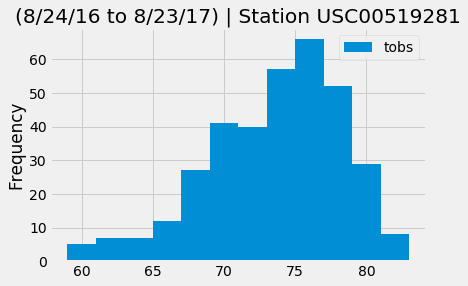

In [33]:
# Plot the temperature data in a histogram with 12 bins
temp_df=pd.DataFrame(temp_obs)
plt.hist(temp_df['tobs'],12)
plt.ylabel("Frequency")
plt.title("(8/24/16 to 8/23/17) | Station " + top_tobs_stn)
plt.legend(["tobs"])
plt.savefig("Images/StationAnalysis_Hawaii_rjr.png")
plt.show()

# Temperature analysis 

In [34]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVG, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [38]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip = calc_temps('2011-02-28','2011-03-05')
trip

[(61.0, 69.75510204081633, 75.0)]

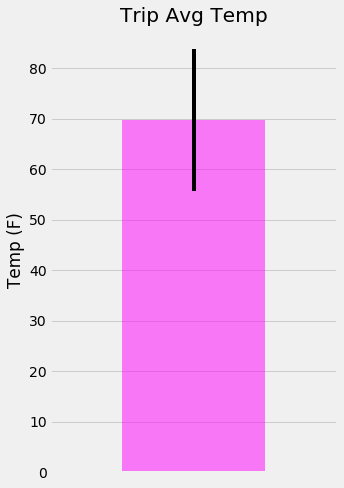

In [44]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
trip_df = pd.DataFrame(trip, columns=['tmin', 'tavg', 'tmax'])
trip_df.plot.bar(y='tavg', yerr=(trip_df['tmax'] - trip_df['tmin']), 
                      title='Trip Avg Temp', color='magenta', alpha=0.5, figsize=(5,7))
plt.xticks(np.arange(1, 1.0))
plt.ylabel("Temp (F)")
plt.tight_layout()
plt.gca().legend_.remove()
plt.savefig("Images/TripAvgTemp_rjr.png")
plt.show()

In [46]:
# Calculate the total amount of rainfall per weather station for your trip dates 
# using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list 
# the station, name, latitude, longitude, and elevation
def precipitation(start_date, end_date):
    
        # Docstring for the function `calc_temps`
    """Precipitation information per weather station
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        A list of tuples containing precipitation amount, station, name, latitude, longitude, and elevation in descending order.
    """
    
    sel = [Measurement.station, 
           Station.name, 
           Station.latitude, 
           Station.longitude, 
           Station.elevation, 
           Measurement.prcp]
    
    return session.query(*sel).\
            filter(Measurement.station == Station.station).filter(Measurement.date >= start_date).\
            filter(Measurement.date <= end_date).\
            group_by(Measurement.station).order_by(Measurement.prcp.desc()).all()

print(precipitation('2011-02-28','2011-03-05'))

[('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 0.02), ('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9, 0.0), ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.0), ('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 0.0), ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 0.0), ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.0), ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, None), ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, None), ('USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6, None)]


## Optional Challenge Assignment

In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [47]:
# Calculate the daily normals for your trip
# Push each tuple of calculations into a list called `normals`
def daily_norms(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_norms("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [49]:
# Set the start and end date of the trip
start_date = '2017-05-12'
end_date ='2017-05-19'

# Use the start and end date to create a range of dates
date_range = session.query(Measurement.date).filter(Measurement.date >= start_date).\
    filter(Measurement.date <= end_date).group_by(Measurement.date).all()

In [51]:
# Strip off the year and save a list of %m-%d strings
# Use list comprehension to get dates 
trip_dates = [x[0] for x in date_range]
trip_dates_no_year = [x[5:] for x in trip_dates]
start = trip_dates_no_year[0]
end = trip_dates_no_year[-1]

In [55]:
# Loop through the list of %m-%d strings and calculate the normals for each date
daily_norms = [session.query(func.min(Measurement.tobs),
                       func.avg(Measurement.tobs),
                       func.max(Measurement.tobs)).filter(func.strftime("%m-%d", Measurement.date) >= start).filter(func.strftime("%m-%d", Measurement.date) <= end).group_by(func.strftime("%m-%d", Measurement.date)).all()]

daily_norms = daily_norms[0]
print("Daily Norms for 05-12 to 05-19")
daily_norms

Daily Norms for 05-12 to 05-19


[(65.0, 73.13793103448276, 79.0),
 (67.0, 73.14285714285714, 79.0),
 (63.0, 73.89285714285714, 80.0),
 (63.0, 73.69090909090909, 79.0),
 (68.0, 74.37931034482759, 80.0),
 (68.0, 74.45, 79.0),
 (68.0, 74.10714285714286, 82.0),
 (65.0, 73.80701754385964, 79.0)]

In [56]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
daily_norms_df= pd.DataFrame(daily_norms,columns=['tmin', 'tavg', 'tmax'])

# Add trip_dates to Pandas DataFrame
daily_norms_df['date']= trip_dates

# Change datatype from element to datetime object on Pandas, makes x axis title to add 
daily_norms_df['date'] = pd.to_datetime(daily_norms_df['date'], format='%Y-%m-%d')

# Set index to date
daily_norms_df.set_index('date',inplace=True)

daily_norms_df

,tmin,tavg,tmax
date,,,
2017-05-12,65.0,73.137931,79.0
2017-05-13,67.0,73.142857,79.0
2017-05-14,63.0,73.892857,80.0
2017-05-15,63.0,73.690909,79.0
2017-05-16,68.0,74.379310,80.0
2017-05-17,68.0,74.450000,79.0
2017-05-18,68.0,74.107143,82.0
2017-05-19,65.0,73.807018,79.0


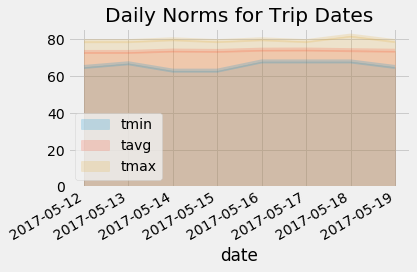

In [57]:
# Plot the daily normals as an area plot with `stacked=False`
daily_norms_df.plot(kind='area', alpha=.2, stacked=False, x_compat=True, title="Daily Norms for Trip Dates")
plt.tight_layout()
plt.savefig("Images/DailyNormals_rjr.png")
plt.show()